# Extract cell level results

In [1]:
import os
import bigfish.stack as stack
import bigfish.plot as plot
import numpy as np

In [2]:
# hard-code the paths of our input and output directories
path_input = "../data/input"
path_output = "../data/output"

In this notebook, we show examples to **extract results at the cell level**. We combine the results of the previous notebooks. As a reminder, segmentation is performed in 2D, but detection can be performed in 2D or 3D. Several steps are developed:
- Presentation of the different formats expected for the segmentation and detection results.
- Detection and filtering of the transcription sites.
- Extraction of the FoV results at the cell levels.
- Cell plots.

In [3]:
recipe = {
    "fov": "fov_1",
    "c": ["dapi", "smfish"],
    "opt": "experience_1",
    "ext": "tif",
    "pattern": "opt_c_fov.ext"}
image = stack.build_stack(recipe, input_folder=path_input) 
print("\r shape: {0}".format(image.shape))
print("\r dtype: {0}".format(image.dtype))

 shape: (1, 2, 23, 650, 500)
 dtype: uint16


In [4]:
rna = image[0, 1, ...]
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))

smfish channel
 shape: (23, 650, 500)
 dtype: uint16


## Read segmentation and detection results

Intermediate results that are saved during the analysis need to follow a specific format:
- **Segmented cells** are saved in a tif file. It should be a 2D array with np.uint8 or np.uint16 dtype. This array is required.
- **Segmented nuclei** are saved in a tif file. It should be a 2D array with np.uint8 or np.uint16 dtype. This array is optional. If None, transcription sites are not identified
- **Spots coordinates** are saved in a npy file or a csv file. It should be a 2D array with np.int64 dtype. This array is optional. If None, spots are not assigned to the segmented cells.
- **Foci coordinates** are saved in a npy file or a csv file. It should be a 2D array with np.int64 dtype. This array is optional. If None, transcription sites are not identified and foci are not assigned to the segmented cells.
- **FoV images** are saved in a png file. It should be a 2D array with np.uint8 or np.uint16 dtype. This array is optional. If None, images of the individual cells are not returned.

In [5]:
# segmented cells
path = os.path.join(path_output, "cell_label.tif")
cell_label = stack.read_image(path)
print("segmented cells")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype))

# segmented nuclei
path = os.path.join(path_output, "nuc_label.tif")
nuc_label = stack.read_image(path)
print("segmented nuclei")
print("\r shape: {0}".format(nuc_label.shape))
print("\r dtype: {0}".format(nuc_label.dtype))

# detected spots
path = os.path.join(path_output, "spots.csv")
spots = stack.read_array_from_csv(path, dtype=np.int64)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype))

# detected foci
path = os.path.join(path_output, "foci.csv")
foci = stack.read_array_from_csv(path, dtype=np.int64)
print("detected foci")
print("\r shape: {0}".format(foci.shape))
print("\r dtype: {0}".format(foci.dtype))

segmented cells
 shape: (650, 500)
 dtype: uint8
segmented nuclei
 shape: (650, 500)
 dtype: uint8
detected spots
 shape: (948, 4)
 dtype: int64
detected foci
 shape: (22, 5)
 dtype: int64


In [6]:
# MIP
rna_mip = stack.rescale(rna, channel_to_stretch=0)
rna_mip = stack.maximum_projection(rna_mip)
print("smfish channel (MIP)")
print("\r shape: {0}".format(rna_mip.shape))
print("\r dtype: {0}".format(rna_mip.dtype))

smfish channel (MIP)
 shape: (650, 500)
 dtype: uint16


## Transcription sites

We identify and remove the **transcription sites** with the functions `bigfish.stack.identify_transcription_site` and `bigfish.stack.remove_transcription_site` respectively. A transcription site is a cluster detected inside the nucleus.

In [7]:
foci_no_ts, transcription_site = stack.identify_transcription_site(nuc_label, foci)
print("detected foci (without transcription sites)")
print("\r shape: {0}".format(foci_no_ts.shape))
print("\r dtype: {0}".format(foci_no_ts.dtype))
print("detected transcription sites")
print("\r shape: {0}".format(transcription_site.shape))
print("\r dtype: {0}".format(transcription_site.dtype))

detected foci (without transcription sites)
 shape: (13, 5)
 dtype: int64
detected transcription sites
 shape: (9, 5)
 dtype: int64


In [8]:
spots_no_ts = stack.remove_transcription_site(spots, transcription_site)
print("detected spots (without transcription sites)")
print("\r shape: {0}".format(spots_no_ts.shape))
print("\r dtype: {0}".format(spots_no_ts.dtype))

detected spots (without transcription sites)
 shape: (902, 4)
 dtype: int64


## Extract cells information

**Cell extraction** is based on cell segmentation. FoV results (segmentation and detection) are assigned to each segmented cells. The function `bigfish.stack.extract_cell` returns a list of dictionaries, one per cell. Each dictionnary can include several keys, for example:
- *cell_coord* for the cell boundary coordinates in 2D.
- *cell_mask* for the cell mask in 2D.
- *nuc_coord* for the nucleus boundary coordinates in 2D. (optional)
- *nuc_mask* for the nucleus mask in 2D. (optional)
- *rna_coord* for the detected RNAs coordinates in 3D or 2D. (optional)
- *image* for the cell original image in 2D. (optional)

In [9]:
fov_results = stack.extract_cell(
    cell_label=cell_label, 
    ndim=3, 
    nuc_label=nuc_label, 
    rna_coord=spots_no_ts, 
    others={"foci": foci_no_ts, "transcription_site": transcription_site},
    image=rna_mip)
print("number of cells identified: {0}".format(len(fov_results)))

number of cells identified: 2


cell 0
 number of rna 436
 number of foci 7
 number of transcription sites 4


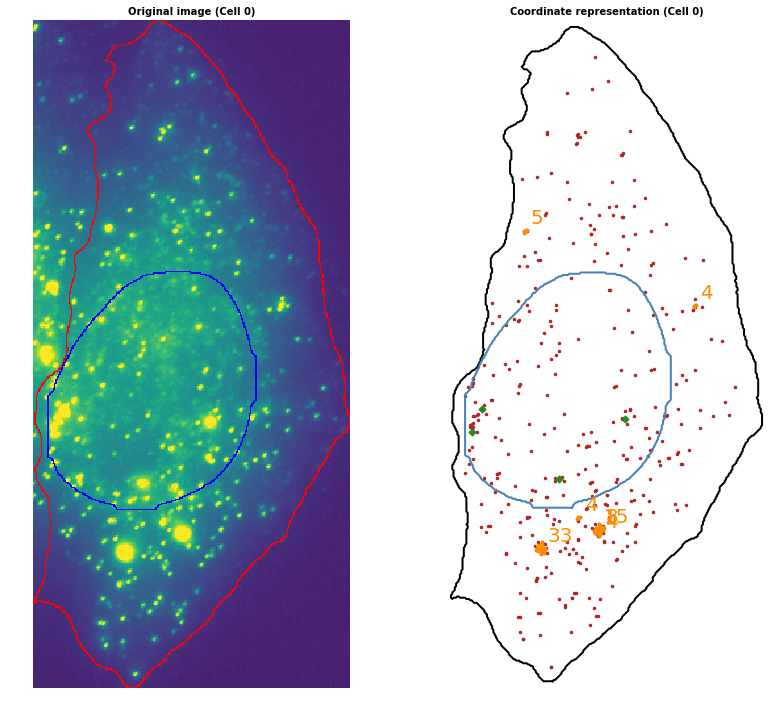

cell 1
 number of rna 466
 number of foci 6
 number of transcription sites 5


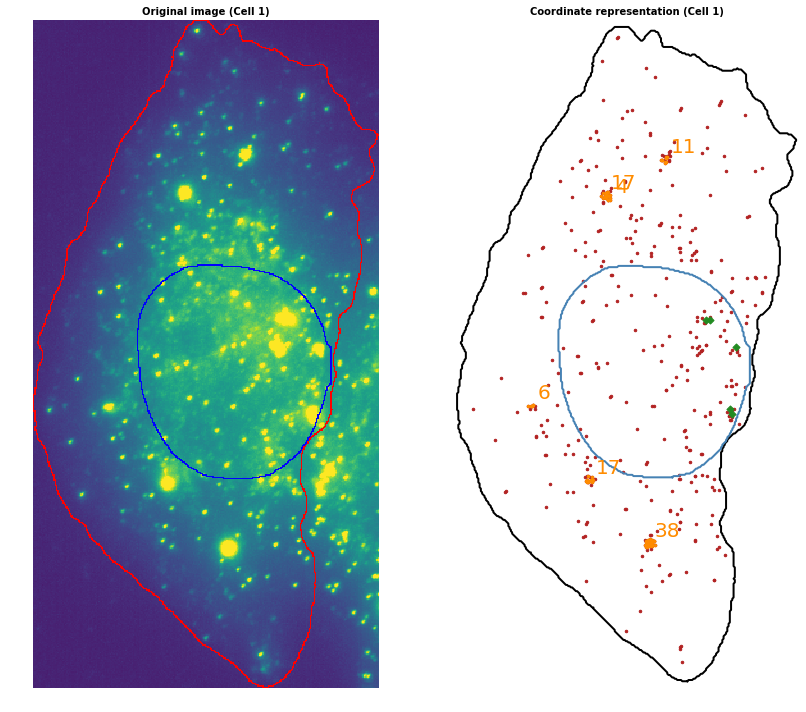

In [10]:
for i, cell_results in enumerate(fov_results):
    print("cell {0}".format(i))
    
    # get cell results
    cell_coord = cell_results["cell_coord"]
    cell_mask = cell_results["cell_mask"]
    nuc_coord = cell_results["nuc_coord"]
    nuc_mask = cell_results["nuc_mask"]
    rna_coord = cell_results["rna_coord"]
    foci_coord = cell_results["foci"]
    ts_coord = cell_results["transcription_site"]
    cell_mip = cell_results["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))
    print("\r number of transcription sites {0}".format(len(ts_coord)))
    
    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, nuc_coord=nuc_coord, 
        rna_coord=rna_coord, foci_coord=foci_coord, other_coord=ts_coord, 
        image=cell_mip, cell_mask=cell_mask, nuc_mask=nuc_mask, 
        title="Cell {0}".format(i), remove_frame=True, framesize=(12, 10))

## Save cell-level results

To save the results obtained at the cell-level, two methods are possible:
- Save each element in a separate file (masks in a tif file, coordinates arrays in a npy or csv file and images in png file).
- Save everything in a **single npz file** (format specific to numpy), assigning each element with a keyword. Functions `bigfish.stack.save_cell_extracted` and `bigfish.stack.read_cell_extracted` can be used for this purpose.

In [11]:
for i, cell_results in enumerate(fov_results):
    
    # save results
    path = os.path.join(path_output, "results_cell_{0}.npz".format(i))
    stack.save_cell_extracted(cell_results, path)

In [12]:
# read results for the first cell of the FoV
path = os.path.join(path_output, "results_cell_0.npz")
cell_results = stack.read_cell_extracted(path, verbose=True)
print(cell_results["rna_coord"])

Available keys: bbox, cell_coord, cell_mask, nuc_coord, nuc_mask, rna_coord, foci, transcription_site, image 

[[  4  41 121  -1]
 [  4 116  66  -1]
 [  4 185  58  -1]
 ...
 [ 21 276  16  -1]
 [ 22 289  31  -1]
 [ 22 289  30  -1]]
